In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import collections
from collections import Counter
import math
import random
import uuid #generate random id
import pickle #to save dictionaries

#modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, explained_variance_score
#catboost, for a better support of categorical data
from catboost import CatBoostClassifier

#visuals
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import dict_of_zones_appearances_with_transitionalZones, res_intodico
import config_origins_chapter0 as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


In [3]:
#avoid this warning until its fixed in IPykernel ; DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
#define parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
#id_run = 'chapter0_'
dico_matching = config.dico_matching
dico_garden_opening_hour = config.dico_garden_opening_hour
dico_BatchID_endhour = config.dico_BatchID_endhour
dico_batchID_previoustransitionlonger60sec = config.dico_batchID_previoustransitionlonger60sec
dico_batchID_previoustransitionmodel = config.dico_batchID_previoustransitionmodel
dico_zone_order = config.dico_zone_order
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')    
path_extracted_data_cleaning_model = os.path.join(path_extracted_data_cleaning,'model')    
#feature for model
li_cont_select = config.li_cont_select
li_bin = config.li_bin
li_cat_select = config.li_cat_select
path__ = os.path.join(path_extracted_data_cleaning,'1secTS')
#create a director if not existing
if not os.path.exists(path__):
    os.makedirs(path__)

# Download Input Data

In [5]:
#download testing datset (with video observations)
df_testing = pd.read_csv(os.path.join(path_extracted_data_cleaning, id_run+'InputCleaning.csv'), 
                         parse_dates=['Timestamp', 'date'], dayfirst=True, sep=';')
df_testing = df_testing[df_testing['algo_type']=='verification'].copy()
df_testing['is_dur_smaller_60sec'] = df_testing['duration_bounded_mn'].map(lambda x: x<1) #for WG in ML-cleaning & TD-cleaning
#save initial dataframe for the ground truch method, which needs to keep VideoAnalyse==3: missed transitions
df_init = df_testing.copy()
#remove the added missing zone for all cleaning methods (we will use df_init for the ground truth computation, 
#which included the video_observation=3)
print(df_testing.shape)
df_testing = df_testing[df_testing['VideoAnalyse'].isin([0,1])]
print(df_testing.shape)
df_testing.head(3)

(870, 35)
(865, 35)


,Timestamp,TagID,HenID,Trackingsystem_Zone,Observed_Zone,PenID,VideoAnalyse,system,date,signalstrength,...,previous_duration_bounded_mn,algo_type,BatchID,previousZone==NextZone,next_duration_bounded_mn,next2zone==Zone,previous2zone==Zone,zone3_match_exist,is_first_observation,is_dur_smaller_60sec
7,2020-10-23 14:19:10,tag_137,hen_140,3_Zone,3_Zone,pen10,1,10 - 12,2020-10-23,12.0,...,0.416667,verification,ID33,True,0.216667,1.0,1.0,1.0,0.0,False
9,2020-10-23 15:33:18,tag_24,hen_170,5_Zone,5_Zone,pen4,1,3 - 5,2020-10-23,11.0,...,0.316667,verification,ID29,True,2.400000,0.0,0.0,0.0,0.0,False
10,2020-10-21 14:00:44,tag_106,hen_29,1_Zone,2_Zone,pen9,0,8 - 9,2020-10-21,6.0,...,2.433333,verification,ID21,True,1.550000,0.0,0.0,0.0,0.0,True


In [6]:
#FR/CR percentage
df_testing.groupby(['VideoAnalyse'])['Timestamp'].agg(lambda x: len(list(x))).reset_index() #43/865=5%%, 822/865=95%

,VideoAnalyse,Timestamp
0,0,43
1,1,822


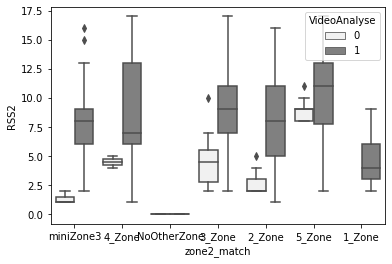

In [33]:
sns.boxplot(x='zone2_match', y='signalstzone2', hue='VideoAnalyse', data=df_testing, color='gray')
plt.ylabel('RSS2')
#plt.title('test dataset')
plt.savefig(os.path.join(path_extracted_data_cleaning,'videoanalysis_testdata_zone2_match.png'), bbox_inches='tight')
plt.show();

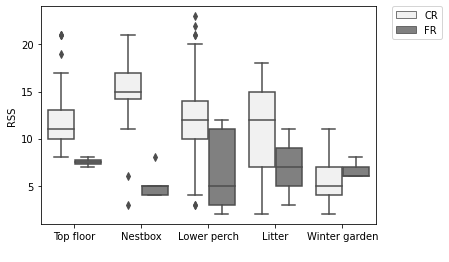

In [48]:
#sns.violinplot(x='Trackingsystem_Zone', y=t, hue='VideoAnalyse', data=df_cl4stat)
dico_int_name = {0:'FR', 1:'CR'}
dico_zone_plot_name = {'1_Zone':'Winter garden',
                       '2_Zone':'Litter',
                       '3_Zone':'Lower perch',
                       '4_Zone':'Nestbox',
                       '5_Zone':'Top floor'}

df_testing['video observations'] = df_testing['VideoAnalyse'].map(lambda x: dico_int_name[x])
df_testing['zone_nice_name'] = df_testing['Trackingsystem_Zone'].map(lambda x: dico_zone_plot_name[x])
order = ['Top floor','Nestbox','Lower perch','Litter','Winter garden']
sns.boxplot(x='zone_nice_name', y='signalstrength', hue='video observations', data=df_testing, color='gray',order=order)
plt.ylabel('RSS')
plt.xlabel(' ')
#legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(path_extracted_data_cleaning,'videoanalysis_testdata_RSS.png'), bbox_inches='tight')
plt.show();

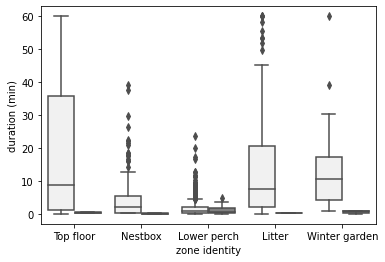

In [47]:
#sns.violinplot(x='Trackingsystem_Zone', y=t, hue='VideoAnalyse', data=df_cl4stat)
sns.boxplot(x='zone_nice_name', y='duration_bounded_mn', hue='video observations', data=df_testing, color='gray', order=order)
plt.xlabel('zone identity')
plt.ylabel('duration (min)')
plt.legend([],[], frameon=False)
plt.savefig(os.path.join(path_extracted_data_cleaning,'videoanalysis_testdata_duration.png'), bbox_inches='tight')
plt.show();

In [6]:
dico_batchID_penID = dict(zip(df_testing['BatchID'].tolist(), df_testing['PenID'].tolist()))
dico_batchID_penID

{'ID33': 'pen10',
 'ID29': 'pen4',
 'ID21': 'pen9',
 'ID40': 'pen10',
 'ID37': 'pen4',
 'ID20': 'pen8',
 'ID4': 'pen4',
 'ID7': 'pen10',
 'ID9': 'pen4',
 'ID36': 'pen3',
 'ID1': 'pen3',
 'ID2': 'pen4',
 'ID3': 'pen8',
 'ID12': 'pen12',
 'ID27': 'pen10',
 'ID30': 'pen5',
 'ID19': 'pen5',
 'ID32': 'pen9',
 'ID31': 'pen8',
 'ID38': 'pen5',
 'ID11': 'pen9',
 'ID10': 'pen9',
 'ID5': 'pen5',
 'ID26': 'pen10',
 'ID35': 'pen12',
 'ID14': 'pen11',
 'ID15': 'pen11',
 'ID13': 'pen12',
 'ID41': 'pen11',
 'ID39': 'pen8',
 'ID28': 'pen3',
 'ID8': 'pen3',
 'ID16': 'pen11',
 'ID6': 'pen8',
 'ID34': 'pen11',
 'ID22': 'pen5',
 'ID25': 'pen8',
 'ID42': 'pen12',
 'ID24': 'pen3',
 'ID18': 'pen3',
 'ID17': 'pen10',
 'ID23': 'pen5'}

In [7]:
display(df_testing[config.li_cont_select].head(3))
display(df_testing[config.li_cat_select].head(3))

,signalstrength,signalstzone2,duration_bounded_mn,next_duration_bounded_mn,previous_duration_bounded_mn,next2zone==Zone,previous2zone==Zone,zone3_match_exist
7,12.0,11.0,1.200000,0.216667,0.416667,1.0,1.0,1.0
9,11.0,7.0,27.983333,2.400000,0.316667,0.0,0.0,0.0
10,6.0,0.0,0.033333,1.550000,2.433333,0.0,0.0,0.0


,Trackingsystem_Zone,zone2_match,previous1_zone,next1_zone,system
7,3_Zone,miniZone3,3_Zone,3_Zone,10 - 12
9,5_Zone,4_Zone,4_Zone,4_Zone,3 - 5
10,1_Zone,NoOtherZone,2_Zone,2_Zone,8 - 9


In [8]:
#download trained model
model = CatBoostClassifier()
model.load_model(os.path.join(path_extracted_data_cleaning_model,'FINAL_Catboost'));

# Model prediction

In [9]:
#predict, and if its wintergarten (i.e. 1_Zone) put =1
df_testing['model_prediction'] = df_testing.apply(lambda x: model.predict(pd.DataFrame(x[li_cont_select+\
                                                                                        li_cat_select]).transpose())[0] if\
                                                       x['Trackingsystem_Zone']!='1_Zone' else 1, axis=1)
#predict false if <60seconds in WG
df_testing.loc[(df_testing['is_dur_smaller_60sec'])&(df_testing['Trackingsystem_Zone']=='1_Zone'), 'model_prediction'] = 0
display(df_testing['model_prediction'].value_counts())

#small testing of a potential excpetion (that actually do not exist n our case :))
if df_testing[(df_testing['is_dur_smaller_60sec'])&(df_testing['Trackingsystem_Zone']=='1_Zone')\
              &(df_testing['is_first_observation'])].shape[0]>0:
    print('WARNING: you have a first observation of a batch that is wintergarten, less than 60seconds, so you need to add the \
    rules as in the computation of 1seconds time serie for the threshold method')
    sys.exit()
df_testing.to_csv(os.path.join(path_extracted_data_cleaning, id_run+'_TestingDatasetWithModelPrediction.csv'), index=False, sep=';')
display(df_testing.head(3))

1    818
0     47
Name: model_prediction, dtype: int64

,Timestamp,TagID,HenID,Trackingsystem_Zone,Observed_Zone,PenID,VideoAnalyse,system,date,signalstrength,...,algo_type,BatchID,previousZone==NextZone,next_duration_bounded_mn,next2zone==Zone,previous2zone==Zone,zone3_match_exist,is_first_observation,is_dur_smaller_60sec,model_prediction
7,2020-10-23 14:19:10,tag_137,hen_140,3_Zone,3_Zone,pen10,1,10 - 12,2020-10-23,12.0,...,verification,ID33,True,0.216667,1.0,1.0,1.0,0.0,False,1
9,2020-10-23 15:33:18,tag_24,hen_170,5_Zone,5_Zone,pen4,1,3 - 5,2020-10-23,11.0,...,verification,ID29,True,2.400000,0.0,0.0,0.0,0.0,False,1
10,2020-10-21 14:00:44,tag_106,hen_29,1_Zone,2_Zone,pen9,0,8 - 9,2020-10-21,6.0,...,verification,ID21,True,1.550000,0.0,0.0,0.0,0.0,True,0


# Select pairs' combinations of batches

In [10]:
#fix random seed for reproducibility
random.seed(0)
#number of combination's pair to run for each size
nbr_comb = 10
#minimum nbr of batches to have in a run
min_nbr_batch = 7 #5 is the minimum for transition reliability, so lets have it to be "7"
#list of batchID
li_batch = df_testing['BatchID'].unique()

#list of disjoints sets with fixed size (i.e. equal number of batches)
li_selected_combination_pairs = []
#to have distinct pairs, we cant have sets with size larger than half of what we have
for nbr_batch in tqdm.tqdm(range(min_nbr_batch, int(len(li_batch)/2))):
    li_sel = []
    #continue adding pairs of set while we dont have the number we want (i.e. nbr_comb)
    while len(li_sel)!=nbr_comb:
        li_pair1 = random.sample(list(li_batch), nbr_batch) #random sampling without replacement
        li_pair2 = random.sample([x for x in li_batch if x not in li_pair1], nbr_batch) 
        li_sel.append([li_pair1,li_pair2])
    li_selected_combination_pairs.extend(li_sel)
#do the one with all batches for final outputs
li_selected_combination_pairs.append([tuple(li_batch),tuple(li_batch)])
print(li_selected_combination_pairs[-3])
print(li_selected_combination_pairs[-2])
#save
pickle.dump(li_selected_combination_pairs,open(os.path.join(path_extracted_data_cleaning,'li_selected_combination_pairs.pkl'),'wb'))

100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 3509.88it/s]

[['ID37', 'ID23', 'ID24', 'ID7', 'ID3', 'ID4', 'ID8', 'ID13', 'ID20', 'ID18', 'ID28', 'ID5', 'ID34', 'ID27', 'ID19', 'ID26', 'ID6', 'ID32', 'ID40', 'ID17'], ['ID11', 'ID35', 'ID41', 'ID36', 'ID21', 'ID22', 'ID29', 'ID42', 'ID30', 'ID9', 'ID15', 'ID2', 'ID1', 'ID25', 'ID31', 'ID16', 'ID12', 'ID38', 'ID10', 'ID14']]
[['ID30', 'ID25', 'ID20', 'ID36', 'ID14', 'ID26', 'ID31', 'ID5', 'ID16', 'ID17', 'ID29', 'ID33', 'ID28', 'ID37', 'ID9', 'ID6', 'ID10', 'ID34', 'ID4', 'ID11'], ['ID2', 'ID3', 'ID1', 'ID39', 'ID42', 'ID23', 'ID19', 'ID8', 'ID13', 'ID7', 'ID21', 'ID15', 'ID18', 'ID32', 'ID24', 'ID22', 'ID35', 'ID41', 'ID27', 'ID12']]


# Create 1sec-categorical time series

In [11]:
for BatchID,df_ in tqdm.tqdm(df_testing[['Trackingsystem_Zone','PenID','HenID','Timestamp','BatchID',
                                         'model_prediction']].groupby(['BatchID'])):

    #select the list of timestamp we want (i.e. at one second level)
    mi = min(df_['Timestamp'].tolist())
    ma = max(df_['Timestamp'].tolist())
    #extend the daterange if the batch is in dico_BatchID_endhour
    if BatchID in dico_BatchID_endhour.keys():
        ma = dt.datetime(ma.year,ma.month,ma.day,dico_BatchID_endhour[BatchID],0,0)
    #print(mi, ma)
    Daterange = pd.date_range(start = mi+dt.timedelta(seconds=(60-mi.second)), 
                              end = ma-dt.timedelta(seconds=(ma.second+1)), 
                              freq = 'S') 
    #print(Daterange[0:2])
    #print(Daterange[-2:])

    ##################################################################################################################
    #print('----------- 1 sec ts: unprocessed records (tracking system method)')
    ### extend to 1 seconds level
    #add missing seconds (i.e. all seconds that never had a record) and fillnan with last non-nan values by propagating last 
    # observation forward to next valHenIDmi = min(df_['Timestamp'].tolist())
    df_ = df_.sort_values('Timestamp', ascending=True)
    df_.set_index('Timestamp', inplace=True)
    df__ = df_.reindex(Daterange, method='ffill').reset_index()
    df__.rename(columns={'index':'Timestamp'}, inplace=True)
    #display(df__.head(3))
    df__.to_csv(os.path.join(path__,'1secTimeSeries_tracking'+str(BatchID)+'.csv'), sep=';', index=False)

    ##################################################################################################################  
    #print('----------- 1 sec ts: from video observation')
    #the reason why we need to have the true observation separately is: if after a missed zone the record was incorrectly 
    #registered, then we would need to say that the observed zone is not the previous_registered zone ("previous1_zone") (as it
    #is so far), but instead :the missed zone. Also, if the first record of a batch was observed to be wrong, then we need
    #the information provided by "Observed_Zone". Hence, we will remove the wrong records except if its the first record
    #of the batch, and extend their observed_zone
    df_init_ = df_init[df_init['BatchID']==BatchID][['VideoAnalyse','Observed_Zone','Timestamp','BatchID',
                                                     'is_first_observation']].copy()
    #remove all the wrong records, keed missed transiotns and correct records
    df_init_ = df_init_[(df_init_['VideoAnalyse']!=0)|(df_init_['is_first_observation'])]
    #then extend it to a 1 second time serie, the same way as we did previosuly for the tracking method and the model method
    df_init_ = df_init_.sort_values('Timestamp',ascending=True)
    df_init_.set_index('Timestamp', inplace=True)
    df_init__ = df_init_.reindex(Daterange, method='ffill').reset_index()
    df_init__.rename(columns={'index':'Timestamp'}, inplace=True)
    df_init__.drop(['is_first_observation'], axis=1, inplace=True)
    #display(df_init__.head(3))
    df_init__.to_csv(os.path.join(path__,'1secTimeSeries_True'+str(BatchID)+'.csv'), sep=';', index=False)

    ##################################################################################################################
    #print('----------- 1 sec ts: TD-method (60 seconds duration threshold)')
    #we use the df_testing (which has not the missed transition, i.e. videoanalyse=3)
    df_threshold = df_testing[df_testing['BatchID']==BatchID][['Trackingsystem_Zone','is_dur_smaller_60sec','Timestamp',
                                                               'BatchID','is_first_observation']].copy()
    #when the first observation of a batch is filtered by this method, then change the zone to be the last non-filtered one
    #oterwise we wont have this one included in the analysis
    if BatchID in dico_batchID_previoustransitionlonger60sec.keys():
        df_threshold.loc[(df_threshold['is_dur_smaller_60sec'])&(df_threshold['is_first_observation']==1),
                         'Trackingsystem_Zone'] = dico_batchID_previoustransitionlonger60sec[BatchID]
        
    #remove the wrong records as defined by this method, keeping the first observations
    df_threshold = df_threshold[(df_threshold['is_dur_smaller_60sec']==False)|(df_threshold['is_first_observation']==1)]

    #then extend it to a 1 second time serie, the same way as we did previously for the tracking method
    df_threshold = df_threshold.sort_values('Timestamp', ascending=True)
    df_threshold.set_index('Timestamp', inplace=True)
    df_threshold_ = df_threshold.reindex(Daterange, method='ffill').reset_index()
    df_threshold_.drop(['is_dur_smaller_60sec','is_first_observation'], axis=1, inplace=True)
    df_threshold_.rename(columns={'index':'Timestamp','Trackingsystem_Zone':'ThresholdOnDuration_Zone'}, inplace=True)
    #display(df_threshold_.head(3))
    df_threshold_.to_csv(os.path.join(path__,'1secTimeSeries_60secThreshold'+str(BatchID)+'.csv'), sep=';', index=False)    

    ##################################################################################################################
    #print('----------- 1 sec ts: ML-method (catboost model)')
    #we use the df_testing (which has not the missed transition, i.e. videoanalyse=3)
    df_model = df_testing[df_testing['BatchID']==BatchID][['Trackingsystem_Zone','model_prediction','Timestamp',
                                                               'BatchID','is_first_observation']].copy()
    #when the first observation of a batch is filtered by this method, then change the zone to be the last non-filtered one
    #otherwise we wont have this one included in the analysis
    if BatchID in dico_batchID_previoustransitionmodel.keys():
        df_model.loc[(df_model['model_prediction']==0)&(df_model['is_first_observation']==1),
                         'Trackingsystem_Zone'] = dico_batchID_previoustransitionmodel[BatchID]
    #remove the wrong records as defined by this method, keeping the first observations
    df_model = df_model[(df_model['model_prediction']==1)|(df_model['is_first_observation']==1)]

    #then extend it to a 1 second time serie, the same way as we did previously for the tracking method
    df_model = df_model.sort_values('Timestamp', ascending=True)
    df_model.set_index('Timestamp', inplace=True)
    df_model_ = df_model.reindex(Daterange, method='ffill').reset_index()
    df_model_.drop(['model_prediction','is_first_observation'], axis=1, inplace=True)
    df_model_.rename(columns={'index':'Timestamp','Trackingsystem_Zone':'Model_Zone'}, inplace=True)
    #display(df_model_.head(3))
    df_model_.to_csv(os.path.join(path__,'1secTimeSeries_model'+str(BatchID)+'.csv'), sep=';', index=False)  

    ##################################################################################################################
    #print('----------- 1 sec ts: BIN-method (binning method with bin=60sec)')
    #First take only the wanted timestamps (1 per seconds)
    #due to the 60 sec period bining, we need to exclude some of the first and last seconds in order to take into account 
    #minutes for which we have the full information only
    DaterangeBIN = [Daterange[i] for i in range(len(Daterange)) if i%60==0]
    #add new timestamp to the initial file
    df_date = pd.DataFrame({'New_Timestamp':DaterangeBIN})
    df_date['New_Timestamp'] = df_date['New_Timestamp'].map(lambda x: pd.to_datetime(x))
    df_bin = pd.merge_asof(df__, df_date, left_on=['Timestamp'], right_on=['New_Timestamp'], direction='forward')

    #Then bin the data
    h = 'Trackingsystem_Zone'
    df_bin = df_bin[[h,'New_Timestamp']].copy()
    df_bin['nbr_sec'] = 1
    df_bin = df_bin.groupby(['New_Timestamp',h])['nbr_sec'].sum().reset_index() #sum to count as we have seconds
    df_bin = df_bin.groupby(['New_Timestamp'])[[h,'nbr_sec']].agg(lambda x: tuple(x)).reset_index()
    df_bin['most_frequent_zone'] = df_bin.apply(lambda x: x[h][x['nbr_sec'].index(max(x['nbr_sec']))], axis=1)
    df_bin['nbr_duration_per_zone'] = df_bin.apply(lambda x: str({x[h][k]:x['nbr_sec'][k] for k in range(len(x[h]))}), axis=1)
    df_bin['day'] = df_bin['New_Timestamp'].map(lambda x: dt.datetime(x.year,x.month,x.day))
    #remove the first point (i.e. when only one sec and not 60)
    df_bin['nbr_sec_total'] = df_bin['nbr_sec'].map(lambda x: sum(x))
    df_bin = df_bin[df_bin['nbr_sec_total']==60]
    df_bin.to_csv(os.path.join(path__ ,'bining'+str(BatchID)+'.csv'), sep=';', index=False)
    #display(df_bin.head(3))    

    #extend to 1sec ts
    df_bin = df_bin[['most_frequent_zone','New_Timestamp']]
    df_bin = df_bin.sort_values('New_Timestamp', ascending=True)
    df_bin.set_index('New_Timestamp', inplace=True)
    df_bin1sec = df_bin.reindex(Daterange, method='bfill').reset_index() #backward otherwise we dont fit our bining definition
    df_bin1sec.rename(columns={'index':'Timestamp','most_frequent_zone':'Binning_Zone'}, inplace=True)
    df_bin1sec.to_csv(os.path.join(path__,'1secTimeSeries_bining'+str(BatchID)+'.csv'), sep=';', index=False)
    #display(df_bin1sec.head(3))

    ############################################## join all and save ##################################################
    df_final = pd.merge(df__, df_bin1sec, on=['Timestamp'], how='outer')
    df_final = pd.merge(df_final, df_init__, on=['Timestamp','BatchID'], how='outer') #video observation
    df_final = pd.merge(df_final, df_threshold_, on=['Timestamp','BatchID'], how='outer')
    df_final = pd.merge(df_final, df_model_, on=['Timestamp','BatchID'], how='outer')
    df_final.to_csv(os.path.join(path__,'1secTimeSeries_ALL_'+str(BatchID)+'.csv'), sep=';', index=False)
    #del df_final, df__, df_bin1sec, df_, df_date, df_bin, df_init__, df_threshold_, df_model_
#shows the final file from the final batch
print(df_final.shape)
df_final.head(3)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:09<00:00,  1.66s/it]

(6360, 11)


,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-16 10:14:00,3_Zone,pen4,hen_73,ID9,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-16 10:14:01,3_Zone,pen4,hen_73,ID9,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-16 10:14:02,3_Zone,pen4,hen_73,ID9,1,3_Zone,1,3_Zone,3_Zone,3_Zone


# Comparing Cleaning Methods over several batch combinations

In [12]:
#start recording the time it last
START_TIME = time.perf_counter()
li_df  = []
is_done = False
for li_batch1, li_batch2 in tqdm.tqdm(li_selected_combination_pairs):

    #select a unique runID per pair of batch combination to save the results of each run with a unique ID
    runID = uuid.uuid1()
    nbr_b = len(li_batch1)
    
    for i,li_batch in enumerate([li_batch1, li_batch2]):
        #dont do the second batch if its the same as the first one, i.e. if its the final output, but print visuals instead for
        #an additional simple verification
        if (li_batch1==li_batch2) & (is_done==True):
            #to sort the yaxis
            li_ts = ['Trackingsystem_Zone','Model_Zone','Observed_Zone','Binning_Zone','ThresholdOnDuration_Zone']
            #for each batch draw 4 timeseries
            for BatchID, df_plt in tqdm.tqdm(df_final.groupby(['BatchID'])):
                display(df_plt.head(3))
                #print(df_plt[df_plt['Binning_Zone'].isnull()].shape)
                df_plt = df_plt[~df_plt['Binning_Zone'].isnull()] #only the last 59 seconds
                df_plt = df_plt.sort_values(['Timestamp']).copy()
                l = len(li_ts) ; c = 1
                fig = plt.figure(figsize=(c*5, l*1))
                for i,v in enumerate(li_ts):
                    df_plt[v] = df_plt[v].map(lambda x: int(dico_zone_order[x]))       
                    plt.subplot(l,c,i+1)
                    plt.plot(df_plt['Timestamp'].tolist(), df_plt[v].tolist())
                    plt.xticks(fontsize=4)
                    plt.yticks(fontsize=4)
                    plt.title(v+' '+BatchID, size=7)
                plt.savefig(os.path.join(path_extracted_data_cleaning, BatchID+'.png'), format='png', bbox_inches='tight', 
                            dpi=300)
                plt.clf()
                plt.close("all")                      
            break
                    
        ##########################################################################################################
        ############################################ open duration TS ############################################
        ##########################################################################################################
        li_df_dur = []
        li_col = ['Trackingsystem_Zone','VideoAnalyse','Model_Zone','Observed_Zone','ThresholdOnDuration_Zone',
                  'PenID','HenID','Timestamp','BatchID']
        for BatchID in li_batch:
            df_final = pd.read_csv(os.path.join(path__,'1secTimeSeries_ALL_'+str(BatchID)+'.csv'), sep=';',
                                   parse_dates=['Timestamp'], dayfirst=True)
            li_df_dur.append(df_final)
        #concat all final 1sec into one big
        df_final = pd.concat(li_df_dur)
        #save only the last one, for human verification
        if li_batch1==li_batch2:
            #add pen ID
            df_final['PenID'] = df_final['BatchID'].map(lambda x: dico_batchID_penID[x])
            df_final.to_csv(os.path.join(path_extracted_data_cleaning,'1secTimeSeries_reliability.csv'), sep=';', index=False)
        #display(df_final.head(3))

        #remove all nan induced by binning method
        x_ = df_final.shape[0]
        df_final = df_final.dropna(how='any', subset=['Trackingsystem_Zone','Model_Zone','Observed_Zone','Binning_Zone',
                                                     'ThresholdOnDuration_Zone'])
        if x_-df_final.shape[0]>(59*len(li_batch)):
            print('ERROR: check your nan ',x_-df_final.shape[0])
            sys.exit()
            
        ##########################################################################################################
        ######################################### create transition data #########################################
        ##########################################################################################################                
        li_df_zone = []
        for c in ['Trackingsystem_Zone','Model_Zone','Observed_Zone','Binning_Zone','ThresholdOnDuration_Zone']:
            #create a dictionary with the amount of time that the bird has been in each zone
            #add transitional zones!!
            df_transition_ = df_final.groupby(['BatchID'])[c].agg(lambda x: dict_of_zones_appearances_with_transitionalZones([int(i.split('_Zone')[0]) for i in x])).reset_index()
            #print(df_transition_[c].iloc[0])
            #create one colonne per zone and add 0 for the zones that does not exists in this datasets but does exists in the other
            for z in [int(i.split('_Zone')[0]) for i in df_final['Trackingsystem_Zone'].unique()]:
                df_transition_[str(z)+'_Zone'] = df_transition_[c].map(lambda x: x.get(z,0))
            #display(df_transition_)
            #put all values in one column and add a column informing on the zone
            df_ = pd.melt(df_transition_, id_vars=['BatchID'], value_vars=df_final['Trackingsystem_Zone'].unique())
            df_.rename(columns={'value':c}, inplace=True)
            li_df_zone.append(df_)
        #merge all transisiont dataframes
        df_transition = li_df_zone[0]
        for df_ in li_df_zone[1:]:
            df_transition = pd.merge(df_, df_transition, on=['BatchID','variable'], how='outer')
        #display(df_transition.head(3))
        #save only the last one for human verification
        if li_batch1==li_batch2:
            #add penID
            df_transition['PenID'] = df_transition['BatchID'].map(lambda x: dico_batchID_penID[x])
            df_transition.to_csv(os.path.join(path_extracted_data_cleaning,'reliability_transition.csv'), sep=';', index=False)

        ##########################################################################################################
        ############################### relevance behavioural data - duration 1secTS #############################
        ##########################################################################################################
        for c in ['Trackingsystem_Zone','Model_Zone','Binning_Zone','ThresholdOnDuration_Zone']:
            li_t = df_final['Observed_Zone'].tolist()
            li_p = df_final[c].tolist()
            res = classification_report(li_t, li_p, output_dict=True, zero_division=0)
            dico_ = res_intodico(res)
            dico_['method'] = c
            dico_['reliability_type'] = 'duration_1secTS'
            dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
            li_df.append(dico_)

        ##########################################################################################################
        ################################## relevance behavioural data - transition ###############################
        ##########################################################################################################
        #does not make sense to compare per minutes the numebr of transition, as we dont really care if they areshifted by few 
        #minutes instead we will compare the number of transition per batch 
        for c in ['Trackingsystem_Zone', 'Model_Zone', 'Binning_Zone','ThresholdOnDuration_Zone']:
            y_true = df_transition['Observed_Zone']
            y_pred = df_transition[c]
            dico_ = {'RMSE': math.sqrt(mean_squared_error(y_true, y_pred)), 
                     'MAE':mean_absolute_error(y_true, y_pred),
                     'explained_variance_score':explained_variance_score(y_true, y_pred)}
            dico_['method'] = c
            dico_['reliability_type'] = 'transitions'
            dico_['support'] = df_transition.shape[0]
            dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
            li_df.append(dico_)
        #per zone for all the batches only
        if li_batch1==li_batch2:
            is_done=True
            for z,df__ in df_transition.groupby('variable'):
                for c in ['Trackingsystem_Zone', 'Model_Zone', 'Binning_Zone','ThresholdOnDuration_Zone']:
                    y_true = df__['Observed_Zone']
                    y_pred = df__[c]                
                    dico_ = {'RMSE': math.sqrt(mean_squared_error(y_true, y_pred)), 
                             'MAE':mean_absolute_error(y_true, y_pred),
                             'explained_variance_score':explained_variance_score(y_true, y_pred)}
                    dico_['method'] = c
                    dico_['reliability_type'] = 'transitions_'+z
                    dico_['support'] = df__.shape[0]
                    dico_['runID']=runID; dico_['li_batch_selected']=li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID']=i
                    li_df.append(dico_)            
            
##########################################################################################################
############################################### Save results #############################################
##########################################################################################################
END_TIME = time.perf_counter()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))
df_results = pd.DataFrame(li_df)
df_results.to_csv(os.path.join(path_extracted_data_cleaning,'ModelComparison_RESULTS.csv'), sep=';', index=False)
display(df_results[['accuracy','RMSE','MAE','explained_variance_score','runID','method',
            'reliability_type']].head(3))

  0%|                                                                                           | 0/42 [00:00<?, ?it/s]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-14 14:01:00,3_Zone,pen3,hen_40,ID1,0,2_Zone,0,2_Zone,2_Zone,2_Zone
1,2020-10-14 14:01:01,3_Zone,pen3,hen_40,ID1,0,2_Zone,0,2_Zone,2_Zone,2_Zone
2,2020-10-14 14:01:02,3_Zone,pen3,hen_40,ID1,0,2_Zone,0,2_Zone,2_Zone,2_Zone



  2%|█▉                                                                                 | 1/42 [00:01<01:03,  1.56s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-14 14:25:00,3_Zone,pen9,hen_110,ID10,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-14 14:25:01,3_Zone,pen9,hen_110,ID10,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-14 14:25:02,3_Zone,pen9,hen_110,ID10,1,3_Zone,1,3_Zone,3_Zone,3_Zone



  5%|███▉                                                                               | 2/42 [00:02<00:59,  1.50s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-16 10:04:00,3_Zone,pen9,hen_5,ID11,1,4_Zone,1,3_Zone,4_Zone,3_Zone
1,2020-10-16 10:04:01,3_Zone,pen9,hen_5,ID11,1,4_Zone,1,3_Zone,4_Zone,3_Zone
2,2020-10-16 10:04:02,3_Zone,pen9,hen_5,ID11,1,4_Zone,1,3_Zone,4_Zone,3_Zone



  7%|█████▉                                                                             | 3/42 [00:04<00:57,  1.47s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-14 14:08:00,2_Zone,pen12,hen_71,ID12,1,2_Zone,1,2_Zone,2_Zone,2_Zone
1,2020-10-14 14:08:01,2_Zone,pen12,hen_71,ID12,1,2_Zone,1,2_Zone,2_Zone,2_Zone
2,2020-10-14 14:08:02,2_Zone,pen12,hen_71,ID12,1,2_Zone,1,2_Zone,2_Zone,2_Zone



 10%|███████▉                                                                           | 4/42 [00:05<00:55,  1.46s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-15 11:35:00,4_Zone,pen12,hen_61,ID13,1,3_Zone,1,4_Zone,5_Zone,4_Zone
1,2020-10-15 11:35:01,4_Zone,pen12,hen_61,ID13,1,3_Zone,1,4_Zone,5_Zone,4_Zone
2,2020-10-15 11:35:02,4_Zone,pen12,hen_61,ID13,1,3_Zone,1,4_Zone,5_Zone,4_Zone



 12%|█████████▉                                                                         | 5/42 [00:06<00:51,  1.40s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-14 14:00:00,3_Zone,pen11,hen_7,ID14,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-14 14:00:01,3_Zone,pen11,hen_7,ID14,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-14 14:00:02,3_Zone,pen11,hen_7,ID14,1,3_Zone,1,3_Zone,3_Zone,3_Zone



 14%|███████████▊                                                                       | 6/42 [00:08<00:51,  1.42s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-15 11:33:00,3_Zone,pen11,hen_108,ID15,1,3_Zone,1,3_Zone,2_Zone,3_Zone
1,2020-10-15 11:33:01,3_Zone,pen11,hen_108,ID15,1,3_Zone,1,3_Zone,2_Zone,3_Zone
2,2020-10-15 11:33:02,3_Zone,pen11,hen_108,ID15,1,3_Zone,1,3_Zone,2_Zone,3_Zone



 17%|█████████████▊                                                                     | 7/42 [00:09<00:48,  1.38s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-16 10:12:00,3_Zone,pen11,hen_165,ID16,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-16 10:12:01,3_Zone,pen11,hen_165,ID16,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-16 10:12:02,3_Zone,pen11,hen_165,ID16,1,3_Zone,1,3_Zone,3_Zone,3_Zone



 19%|███████████████▊                                                                   | 8/42 [00:11<00:47,  1.41s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-16 11:35:00,4_Zone,pen10,hen_65,ID17,1,4_Zone,1,4_Zone,4_Zone,4_Zone
1,2020-10-16 11:35:01,4_Zone,pen10,hen_65,ID17,1,4_Zone,1,4_Zone,4_Zone,4_Zone
2,2020-10-16 11:35:02,4_Zone,pen10,hen_65,ID17,1,4_Zone,1,4_Zone,4_Zone,4_Zone



 21%|█████████████████▊                                                                 | 9/42 [00:12<00:40,  1.23s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-23 16:09:00,2_Zone,pen3,hen_13,ID18,1,2_Zone,1,2_Zone,2_Zone,2_Zone
1,2020-10-23 16:09:01,2_Zone,pen3,hen_13,ID18,1,2_Zone,1,2_Zone,2_Zone,2_Zone
2,2020-10-23 16:09:02,2_Zone,pen3,hen_13,ID18,1,2_Zone,1,2_Zone,2_Zone,2_Zone



 24%|███████████████████▌                                                              | 10/42 [00:13<00:36,  1.15s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-21 12:23:00,2_Zone,pen5,hen_82,ID19,1,2_Zone,1,2_Zone,2_Zone,2_Zone
1,2020-10-21 12:23:01,2_Zone,pen5,hen_82,ID19,1,2_Zone,1,2_Zone,2_Zone,2_Zone
2,2020-10-21 12:23:02,2_Zone,pen5,hen_82,ID19,1,2_Zone,1,2_Zone,2_Zone,2_Zone



 26%|█████████████████████▍                                                            | 11/42 [00:14<00:38,  1.25s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-14 14:01:00,2_Zone,pen4,hen_50,ID2,1,2_Zone,1,2_Zone,2_Zone,2_Zone
1,2020-10-14 14:01:01,2_Zone,pen4,hen_50,ID2,1,2_Zone,1,2_Zone,2_Zone,2_Zone
2,2020-10-14 14:01:02,2_Zone,pen4,hen_50,ID2,1,2_Zone,1,2_Zone,2_Zone,2_Zone



 29%|███████████████████████▍                                                          | 12/42 [00:15<00:38,  1.29s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-21 12:00:00,2_Zone,pen8,hen_51,ID20,1,2_Zone,1,2_Zone,2_Zone,2_Zone
1,2020-10-21 12:00:01,2_Zone,pen8,hen_51,ID20,1,2_Zone,1,2_Zone,2_Zone,2_Zone
2,2020-10-21 12:00:02,2_Zone,pen8,hen_51,ID20,1,2_Zone,1,2_Zone,2_Zone,2_Zone



 31%|█████████████████████████▍                                                        | 13/42 [00:17<00:39,  1.38s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-21 12:01:00,3_Zone,pen9,hen_29,ID21,1,4_Zone,1,3_Zone,4_Zone,3_Zone
1,2020-10-21 12:01:01,4_Zone,pen9,hen_29,ID21,1,4_Zone,1,4_Zone,4_Zone,4_Zone
2,2020-10-21 12:01:02,4_Zone,pen9,hen_29,ID21,1,4_Zone,1,4_Zone,4_Zone,4_Zone



 33%|███████████████████████████▎                                                      | 14/42 [00:18<00:38,  1.39s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-14 08:10:00,4_Zone,pen5,hen_32,ID22,1,4_Zone,1,4_Zone,4_Zone,4_Zone
1,2020-10-14 08:10:01,4_Zone,pen5,hen_32,ID22,1,4_Zone,1,4_Zone,4_Zone,4_Zone
2,2020-10-14 08:10:02,4_Zone,pen5,hen_32,ID22,1,4_Zone,1,4_Zone,4_Zone,4_Zone



 36%|█████████████████████████████▎                                                    | 15/42 [00:20<00:37,  1.39s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-15 12:34:00,4_Zone,pen5,hen_21,ID23,1,4_Zone,1,4_Zone,4_Zone,4_Zone
1,2020-10-15 12:34:01,4_Zone,pen5,hen_21,ID23,1,4_Zone,1,4_Zone,4_Zone,4_Zone
2,2020-10-15 12:34:02,4_Zone,pen5,hen_21,ID23,1,4_Zone,1,4_Zone,4_Zone,4_Zone



 38%|███████████████████████████████▏                                                  | 16/42 [00:21<00:35,  1.35s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-15 14:56:00,4_Zone,pen3,hen_104,ID24,1,4_Zone,1,4_Zone,4_Zone,4_Zone
1,2020-10-15 14:56:01,4_Zone,pen3,hen_104,ID24,1,4_Zone,1,4_Zone,4_Zone,4_Zone
2,2020-10-15 14:56:02,4_Zone,pen3,hen_104,ID24,1,4_Zone,1,4_Zone,4_Zone,4_Zone



 40%|█████████████████████████████████▏                                                | 17/42 [00:23<00:35,  1.42s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-16 07:59:00,4_Zone,pen8,hen_124,ID25,1,4_Zone,1,4_Zone,4_Zone,4_Zone
1,2020-10-16 07:59:01,4_Zone,pen8,hen_124,ID25,1,4_Zone,1,4_Zone,4_Zone,4_Zone
2,2020-10-16 07:59:02,4_Zone,pen8,hen_124,ID25,1,4_Zone,1,4_Zone,4_Zone,4_Zone



 43%|███████████████████████████████████▏                                              | 18/42 [00:24<00:34,  1.44s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-17 09:49:00,2_Zone,pen10,hen_172,ID26,1,2_Zone,1,2_Zone,2_Zone,2_Zone
1,2020-10-17 09:49:01,2_Zone,pen10,hen_172,ID26,1,2_Zone,1,2_Zone,2_Zone,2_Zone
2,2020-10-17 09:49:02,2_Zone,pen10,hen_172,ID26,1,2_Zone,1,2_Zone,2_Zone,2_Zone



 45%|█████████████████████████████████████                                             | 19/42 [00:25<00:31,  1.39s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-21 11:58:00,2_Zone,pen10,hen_54,ID27,1,2_Zone,1,2_Zone,2_Zone,2_Zone
1,2020-10-21 11:58:01,2_Zone,pen10,hen_54,ID27,1,2_Zone,1,2_Zone,2_Zone,2_Zone
2,2020-10-21 11:58:02,2_Zone,pen10,hen_54,ID27,1,2_Zone,1,2_Zone,2_Zone,2_Zone



 48%|███████████████████████████████████████                                           | 20/42 [00:27<00:31,  1.42s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-23 14:28:00,5_Zone,pen3,hen_86,ID28,1,5_Zone,1,5_Zone,5_Zone,5_Zone
1,2020-10-23 14:28:01,5_Zone,pen3,hen_86,ID28,1,5_Zone,1,5_Zone,5_Zone,5_Zone
2,2020-10-23 14:28:02,5_Zone,pen3,hen_86,ID28,1,5_Zone,1,5_Zone,5_Zone,5_Zone



 50%|█████████████████████████████████████████                                         | 21/42 [00:28<00:28,  1.38s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-23 13:59:00,5_Zone,pen4,hen_170,ID29,1,5_Zone,1,5_Zone,5_Zone,5_Zone
1,2020-10-23 13:59:01,5_Zone,pen4,hen_170,ID29,1,5_Zone,1,5_Zone,5_Zone,5_Zone
2,2020-10-23 13:59:02,5_Zone,pen4,hen_170,ID29,1,5_Zone,1,5_Zone,5_Zone,5_Zone



 52%|██████████████████████████████████████████▉                                       | 22/42 [00:30<00:27,  1.38s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-14 14:22:00,3_Zone,pen8,hen_173,ID3,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-14 14:22:01,3_Zone,pen8,hen_173,ID3,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-14 14:22:02,3_Zone,pen8,hen_173,ID3,1,3_Zone,1,3_Zone,3_Zone,3_Zone



 55%|████████████████████████████████████████████▉                                     | 23/42 [00:31<00:26,  1.37s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-23 14:16:00,2_Zone,pen5,hen_12,ID30,1,3_Zone,1,2_Zone,2_Zone,2_Zone
1,2020-10-23 14:16:01,2_Zone,pen5,hen_12,ID30,1,3_Zone,1,2_Zone,2_Zone,2_Zone
2,2020-10-23 14:16:02,2_Zone,pen5,hen_12,ID30,1,3_Zone,1,2_Zone,2_Zone,2_Zone



 57%|██████████████████████████████████████████████▊                                   | 24/42 [00:32<00:24,  1.36s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-23 14:26:00,3_Zone,pen8,hen_147,ID31,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-23 14:26:01,3_Zone,pen8,hen_147,ID31,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-23 14:26:02,3_Zone,pen8,hen_147,ID31,1,3_Zone,1,3_Zone,3_Zone,3_Zone



 60%|████████████████████████████████████████████████▊                                 | 25/42 [00:34<00:22,  1.34s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-23 14:28:00,3_Zone,pen9,hen_19,ID32,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-23 14:28:01,3_Zone,pen9,hen_19,ID32,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-23 14:28:02,3_Zone,pen9,hen_19,ID32,1,3_Zone,1,3_Zone,3_Zone,3_Zone



 62%|██████████████████████████████████████████████████▊                               | 26/42 [00:35<00:21,  1.33s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-23 14:16:00,2_Zone,pen10,hen_140,ID33,1,2_Zone,1,2_Zone,2_Zone,2_Zone
1,2020-10-23 14:16:01,2_Zone,pen10,hen_140,ID33,1,2_Zone,1,2_Zone,2_Zone,2_Zone
2,2020-10-23 14:16:02,2_Zone,pen10,hen_140,ID33,1,2_Zone,1,2_Zone,2_Zone,2_Zone



 64%|████████████████████████████████████████████████████▋                             | 27/42 [00:36<00:20,  1.35s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-22 07:30:00,2_Zone,pen11,hen_9,ID34,1,2_Zone,1,2_Zone,2_Zone,2_Zone
1,2020-10-22 07:30:01,2_Zone,pen11,hen_9,ID34,1,2_Zone,1,2_Zone,2_Zone,2_Zone
2,2020-10-22 07:30:02,2_Zone,pen11,hen_9,ID34,1,2_Zone,1,2_Zone,2_Zone,2_Zone



 67%|██████████████████████████████████████████████████████▋                           | 28/42 [00:38<00:19,  1.41s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-23 14:01:00,4_Zone,pen12,hen_68,ID35,1,4_Zone,1,4_Zone,4_Zone,4_Zone
1,2020-10-23 14:01:01,4_Zone,pen12,hen_68,ID35,1,4_Zone,1,4_Zone,4_Zone,4_Zone
2,2020-10-23 14:01:02,4_Zone,pen12,hen_68,ID35,1,4_Zone,1,4_Zone,4_Zone,4_Zone



 69%|████████████████████████████████████████████████████████▌                         | 29/42 [00:39<00:18,  1.42s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-24 15:01:00,3_Zone,pen3,hen_94,ID36,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-24 15:01:01,3_Zone,pen3,hen_94,ID36,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-24 15:01:02,3_Zone,pen3,hen_94,ID36,1,3_Zone,1,3_Zone,3_Zone,3_Zone



 71%|██████████████████████████████████████████████████████████▌                       | 30/42 [00:41<00:17,  1.44s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-24 15:58:00,4_Zone,pen4,hen_128,ID37,1,4_Zone,1,4_Zone,4_Zone,4_Zone
1,2020-10-24 15:58:01,4_Zone,pen4,hen_128,ID37,1,4_Zone,1,4_Zone,4_Zone,4_Zone
2,2020-10-24 15:58:02,4_Zone,pen4,hen_128,ID37,1,4_Zone,1,4_Zone,4_Zone,4_Zone



 74%|████████████████████████████████████████████████████████████▌                     | 31/42 [00:42<00:14,  1.30s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-24 15:02:00,3_Zone,pen5,hen_21,ID38,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-24 15:02:01,3_Zone,pen5,hen_21,ID38,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-24 15:02:02,3_Zone,pen5,hen_21,ID38,1,3_Zone,1,3_Zone,3_Zone,3_Zone



 76%|██████████████████████████████████████████████████████████████▍                   | 32/42 [00:43<00:12,  1.29s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-24 15:01:00,3_Zone,pen8,hen_158,ID39,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-24 15:01:01,3_Zone,pen8,hen_158,ID39,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-24 15:01:02,3_Zone,pen8,hen_158,ID39,1,3_Zone,1,3_Zone,3_Zone,3_Zone



 79%|████████████████████████████████████████████████████████████████▍                 | 33/42 [00:44<00:11,  1.32s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-15 11:33:00,4_Zone,pen4,hen_153,ID4,1,4_Zone,1,4_Zone,4_Zone,4_Zone
1,2020-10-15 11:33:01,4_Zone,pen4,hen_153,ID4,1,4_Zone,1,4_Zone,4_Zone,4_Zone
2,2020-10-15 11:33:02,4_Zone,pen4,hen_153,ID4,1,4_Zone,1,4_Zone,4_Zone,4_Zone



 81%|██████████████████████████████████████████████████████████████████▍               | 34/42 [00:46<00:10,  1.29s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-24 15:02:00,3_Zone,pen10,hen_46,ID40,1,3_Zone,1,3_Zone,2_Zone,3_Zone
1,2020-10-24 15:02:01,3_Zone,pen10,hen_46,ID40,1,3_Zone,1,3_Zone,2_Zone,3_Zone
2,2020-10-24 15:02:02,3_Zone,pen10,hen_46,ID40,1,3_Zone,1,3_Zone,2_Zone,3_Zone



 83%|████████████████████████████████████████████████████████████████████▎             | 35/42 [00:47<00:09,  1.31s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-22 07:31:00,3_Zone,pen11,hen_99,ID41,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-22 07:31:01,3_Zone,pen11,hen_99,ID41,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-22 07:31:02,3_Zone,pen11,hen_99,ID41,1,3_Zone,1,3_Zone,3_Zone,3_Zone



 86%|██████████████████████████████████████████████████████████████████████▎           | 36/42 [00:48<00:08,  1.35s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-24 15:01:00,3_Zone,pen12,hen_149,ID42,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-24 15:01:01,3_Zone,pen12,hen_149,ID42,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-24 15:01:02,3_Zone,pen12,hen_149,ID42,1,3_Zone,1,3_Zone,3_Zone,3_Zone



 88%|████████████████████████████████████████████████████████████████████████▏         | 37/42 [00:49<00:06,  1.26s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-15 11:32:00,3_Zone,pen5,hen_101,ID5,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-15 11:32:01,3_Zone,pen5,hen_101,ID5,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-15 11:32:02,3_Zone,pen5,hen_101,ID5,1,3_Zone,1,3_Zone,3_Zone,3_Zone



 90%|██████████████████████████████████████████████████████████████████████████▏       | 38/42 [00:51<00:05,  1.25s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-15 11:21:00,3_Zone,pen8,hen_146,ID6,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-15 11:21:01,3_Zone,pen8,hen_146,ID6,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-15 11:21:02,3_Zone,pen8,hen_146,ID6,1,3_Zone,1,3_Zone,3_Zone,3_Zone



 93%|████████████████████████████████████████████████████████████████████████████▏     | 39/42 [00:51<00:03,  1.10s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-15 11:00:00,3_Zone,pen10,hen_139,ID7,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-15 11:00:01,3_Zone,pen10,hen_139,ID7,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-15 11:00:02,3_Zone,pen10,hen_139,ID7,1,3_Zone,1,3_Zone,3_Zone,3_Zone



 95%|██████████████████████████████████████████████████████████████████████████████    | 40/42 [00:53<00:02,  1.20s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-16 09:57:00,4_Zone,pen3,hen_25,ID8,1,4_Zone,1,4_Zone,4_Zone,4_Zone
1,2020-10-16 09:57:01,4_Zone,pen3,hen_25,ID8,1,4_Zone,1,4_Zone,4_Zone,4_Zone
2,2020-10-16 09:57:02,4_Zone,pen3,hen_25,ID8,1,4_Zone,1,4_Zone,4_Zone,4_Zone



 98%|████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:54<00:01,  1.29s/it]

,Timestamp,Trackingsystem_Zone,PenID,HenID,BatchID,model_prediction,Binning_Zone,VideoAnalyse,Observed_Zone,ThresholdOnDuration_Zone,Model_Zone
0,2020-10-16 10:14:00,3_Zone,pen4,hen_73,ID9,1,3_Zone,1,3_Zone,3_Zone,3_Zone
1,2020-10-16 10:14:01,3_Zone,pen4,hen_73,ID9,1,3_Zone,1,3_Zone,3_Zone,3_Zone
2,2020-10-16 10:14:02,3_Zone,pen4,hen_73,ID9,1,3_Zone,1,3_Zone,3_Zone,3_Zone



100%|████████████████████████████████████████████████████████████████████████████████| 141/141 [11:54<00:00,  5.07s/it]


Total running time: 11.90 mn


,accuracy,RMSE,MAE,explained_variance_score,runID,method,reliability_type
0,0.990674,NaN,NaN,NaN,484e835c-a346-11eb-a877-089798b63972,Trackingsystem_Zone,duration_1secTS
1,0.999696,NaN,NaN,NaN,484e835c-a346-11eb-a877-089798b63972,Model_Zone,duration_1secTS
2,0.972307,NaN,NaN,NaN,484e835c-a346-11eb-a877-089798b63972,Binning_Zone,duration_1secTS
